![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Aprendizaje por transferencia

En este notebook usará  modelos previamente entrenados para la detección de rostros y la predicción de edad y genero, es decir usará aprendizaje por transferencia o *transfer learning*.

## Instrucciones Generales

Este notebook usará inicialmente la librería [MTCNN](https://github.com/ipazc/mtcnn) para detectar rostros en una imagen, y posteriormente reutilizará el modelo VGGFace para predecir la edad y el genero de los rostros. En el siguente paper puede conocer más detalles del modelo VGGFace: *Qawaqneh, Z., Mallouh, A. A., & Barkana, B. D. (2017). Deep convolutional neural network for age estimation based on VGG-face model. arXiv preprint arXiv:1709.01664.*. https://arxiv.org/abs/1709.01664
  
Para realizar la actividad, solo siga las indicaciones asociadas a cada celda del notebook. 

## Importar imagenes y librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
from matplotlib import pyplot
from PIL import Image
from numpy import asarray

In [3]:
import os
os.chdir('..')

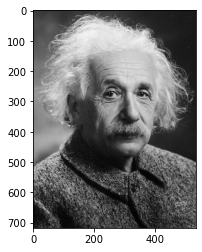

In [8]:
from skimage import io
filename = "https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/face_1.jpeg"
pixels = io.imread(filename, format='jpeg')
pyplot.imshow(pixels)

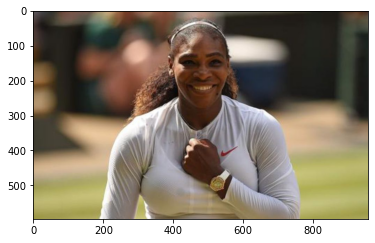

In [10]:
filename = "https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/face_2.jpeg"
pixels = io.imread(filename, format='jpeg')
pyplot.imshow(pixels)

## Extraer rostro de una imagen

Para ejecutar esta sección del código debe instalar la librería MTCNN con el comando *!pip install mtcnn*

In [11]:
# Importación detector de rostros
from mtcnn.mtcnn import MTCNN

# Definición detector de rostros
detector = MTCNN()
results = detector.detect_faces(pixels)
results

1/1 [==============================] - 0s 101ms/step


[{'box': [396, 67, 159, 201],
  'confidence': 0.999985933303833,
  'keypoints': {'left_eye': (447, 148),
   'right_eye': (521, 148),
   'nose': (490, 188),
   'mouth_left': (444, 212),
   'mouth_right': (526, 211)}}]

In [15]:
# Función para extraer rostros
def get_face(img):
    # Carga de imagen
    pixels = io.imread(img, format='jpeg')
    results = detector.detect_faces(pixels)
    # Extracción del rosto
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    # Reescalar imagen a tamaño específico
    required_size=(224, 224)
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    # Retornar rostro
    return face_array

1/1 [==============================] - 0s 40ms/step


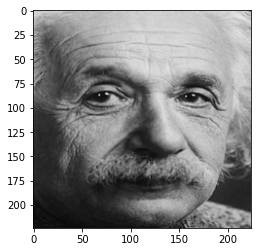

In [16]:
img1 = get_face("https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/face_1.jpeg")
pyplot.imshow(img1)

1/1 [==============================] - 0s 20ms/step


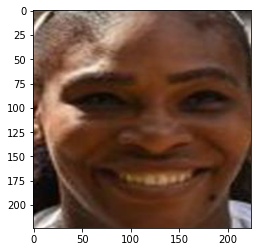

In [17]:
img2 = get_face("https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/face_2.jpeg")
pyplot.imshow(img2)

## Generar embbeding (vector) para cada rostro

Para ejecutar esta sección del código deben instalar la siguiente librería *!pip install keras_vggface*

In [18]:
from keras_vggface.vggface import VGGFace
import numpy as np

Si al instalar la librería sigue presentando algun error al cargarla, por favor correr el siguiente código en una celda adicional.
<code>
import sys
path = '\\'.join(sys.executable.split('\\')[:-1])
filename = path + "\\lib\\site-packages\\keras_vggface\\models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
</code>

In [19]:
# Definición modelo vggface
model = VGGFace(model='resnet50')

# impresión de tamaño de inputs y outputs
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_4')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


In [20]:
# Predicción embedding del modelo para rostro 1
yhat1 = model.predict(img1[np.newaxis,:,:,:])
print(yhat1.shape)
yhat1

1/1 [==============================] - 1s 812ms/step
(1, 8631)


array([[2.1525143e-06, 9.2734888e-07, 8.3095993e-06, ..., 2.3632145e-05,
        5.0733644e-05, 1.0955352e-05]], dtype=float32)

In [21]:
# Predicción embedding del modelo para rostro 2
yhat2 = model.predict(img2[np.newaxis,:,:,:])
print(yhat2.shape)
yhat2

1/1 [==============================] - 0s 79ms/step
(1, 8631)


array([[1.0550224e-07, 6.4673515e-07, 1.0421090e-06, ..., 4.2140287e-05,
        2.2442209e-06, 3.0531999e-06]], dtype=float32)

## Predecir genero y edad

Para ejecutar esta sección del código debe instalar la librería omegaconf con el comando *!pip install omegaconf*. Adicionalmente, debe descargar un archivo tipo '.hdf5' donde se encuentran los pesos calibrados del modelo preentrenado, esto se realiza con el código de la siguiente celda. 

In [22]:
import requests

# Definir dirección URL donde se encuentra el archivo 
remote_url = 'https://github.com/yu4u/age-gender-estimation/releases/download/v0.6/EfficientNetB3_224_weights.11-3.44.hdf5'
# Definir nombre del archivo
local_file = 'datasets/EfficientNetB3_224_weights.11-3.44.hdf5'
# Hacer requerimiento con la función request.get() y guardar archivo
data = requests.get(remote_url)
with open(local_file, 'wb')as file:
    file.write(data.content)

In [23]:
# Importación librerías
from tensorflow.keras import applications
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from omegaconf import OmegaConf
from pathlib import Path

WEIGHTS_FILE = 'datasets/EfficientNetB3_224_weights.11-3.44.hdf5'
model_name, img_size = Path(WEIGHTS_FILE).stem.split("_")[:2]
cfg = OmegaConf.from_dotlist([f"model.model_name={model_name}", f"model.img_size={img_size}"])

In [24]:
# Definición modelo
def get_model(cfg):
    base_model = getattr(applications, cfg.model.model_name)(
        include_top=False,
        input_shape=(cfg.model.img_size, cfg.model.img_size, 3),
        pooling="avg"
    )
    features = base_model.output
    # Capa adicional para predicción de genero
    pred_gender = Dense(units=2, activation="softmax", name="pred_gender")(features)
    # Capa adicional para predicción de edad
    pred_age = Dense(units=101, activation="softmax", name="pred_age")(features)
    model = Model(inputs=base_model.input, outputs=[pred_gender, pred_age])
    return model

In [25]:
# Cargar modelo con set de parámetros
model = get_model(cfg)
model.load_weights(WEIGHTS_FILE)

In [41]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']    

 block2a_expand_conv (Conv2D)   (None, 112, 112, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 14  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_activation (Activation  (None, 28, 28, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 576)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 14, 14, 96)   55296       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 96)  384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 96)   0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block4e_project_bn (BatchNorma  (None, 14, 14, 96)  384         ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 14, 14, 96)   0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 14, 14, 96)   0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 14, 14, 576)  55296       ['block4e_add[0][0]']            
          

                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 14, 14, 816)  3264       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 14, 14, 816)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 816)  20400      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_b

 ivation)                                                                                         
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 14, 14, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 14, 14, 816)  3264       ['block5e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 14, 14, 816)  0          ['block5e_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block6b_activation (Activation  (None, 7, 7, 1392)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1392)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 7, 7, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
          

                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1392)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 7, 7, 232)    322944      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 7, 7, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block7b_drop (Dropout)         (None, 7, 7, 384)    0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_add (Add)              (None, 7, 7, 384)    0           ['block7b_drop[0][0]',           
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 1536)   589824      ['block7b_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activ

In [39]:
# Predicciónes del modelo imagen 1
results = model.predict(img1[np.newaxis,:,:,:])

1/1 [==============================] - 2s 2s/step


In [40]:
# Predicciones imagen 1
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()
predicted_genere = 'hombre' if (results[0][0][1] >= 0.5) else 'mujer'

print('Edad imagen 1: ', predicted_ages)
print('Genero imagen 1: ', predicted_genere)

Edad imagen 1:  [50.73448122]
Genero imagen 1:  mujer


In [28]:
# Predicciónes del modelo imagen 2
results = model.predict(img2[np.newaxis,:,:,:])

1/1 [==============================] - 0s 99ms/step


In [29]:
# Predicciones imagen 2
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()
predicted_genere = 'hombre' if (results[0][0][1] >= 0.5) else 'mujer'

print('Edad imagen 2: ', predicted_ages)
print('Genero imagen 2: ', predicted_genere)

Edad imagen 2:  [25.6407973]
Genero imagen 2:  mujer
